<a href="https://colab.research.google.com/github/vadim-privalov/Sorevnovania/blob/main/%D0%A1%D1%82%D1%80%D0%B0%D1%85%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D0%BE%D0%BB%D0%B8%D1%81_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D1%80%D0%B5%D0%B4%D1%8C%D1%8F%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** 
Цель этих соревнований — предоставить забавный и доступный для всех набор табличных данных. Эти соревнования отлично подойдут тем, кто ищет что-то среднее между соревнованием Titanic Getting Started и избранным соревнованием. Если вы признанный мастер соревнований или гроссмейстер, это, вероятно, не будет для вас большой проблемой. Мы рекомендуем вам избегать перенасыщения таблицы лидеров.

Для каждого ежемесячного соревнования мы будем предлагать товары Kaggle для трех лучших команд. И, наконец, поскольку мы хотим, чтобы эти соревнования были больше связаны с обучением, мы ограничиваем размер команды до 3 человек.

Набор данных, используемый для этого конкурса, является синтетическим, но основан на реальном наборе данных и сгенерирован с использованием CTGAN . Исходный набор данных предназначен для прогнозирования того, будет ли предъявлена ​​претензия по страховому полису. Хотя функции анонимны, они имеют свойства, относящиеся к реальным функциям.

Удачи и приятного времяпровождения! 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from google.colab import files

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf # импортируем tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, SpatialDropout1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
import zipfile # для работы с архивами zip

import os
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline
# устанавливаем свежий Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=6f094f6575b5ff114122f7d0b112d19762f217d982fc2ae472533d66ecdc96ca
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv(filepath_or_buffer = "/content/drive/MyDrive/my_databases/tabular-playground-series-sep-2021/train.csv",
                           sep = ',')
train

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.108590,0.004314,-37.566,0.017364,0.289150,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.10,1.01770,1
1,1,0.100900,0.299610,11822.000,0.276500,0.459700,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.00,0.28359,0
2,2,0.178030,-0.006980,907.270,0.272140,0.459480,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.20,0.40690,1
3,3,0.152360,0.007259,780.100,0.025179,0.519470,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.10,0.51486,1
4,4,0.116230,0.502900,-109.150,0.297910,0.344900,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957914,957914,0.098979,0.202530,2192.100,0.348010,0.276430,-0.84065,2214.20,26246.0,1.061600e+15,...,-51.2970,1.7323,20.76300,14.74400,27415.00,1.2160,2.139400e+13,2612.00,0.42597,0
957915,957915,0.134930,0.413600,1050.100,0.000521,-0.001246,1.76990,3519.90,862290.0,7.321400e+13,...,-41.4180,2.6986,-1.09760,-1.09980,13826.00,1.3320,1.829400e+17,3300.50,0.92974,1
957916,957916,0.104660,0.473510,2415.400,0.252230,0.196970,-0.82323,3044.90,13832.0,2.693300e+12,...,-15.9670,1.6843,1.07590,16.64600,8655.10,1.1113,1.925800e+16,297.61,0.91446,0
957917,957917,0.118190,0.320870,657.860,0.237290,0.260250,-0.71237,173.20,20811.0,9.711000e+14,...,-2.8375,1.3006,132.50000,8.53050,3842.10,1.1941,1.248300e+16,5212.10,0.20942,1


In [4]:
test = pd.read_csv(filepath_or_buffer = "/content/drive/MyDrive/my_databases/tabular-playground-series-sep-2021/test.csv",
                           sep = ',')
test

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
0,957919,0.165850,0.487050,1295.00,0.023100,0.31900,0.901880,573.29,3743.7,2.705700e+12,...,0.162530,-22.1890,2.0655,0.430880,-10.7410,81606.00,1.1940,1.980400e+14,2017.10,0.46357
1,957920,0.129650,0.373480,1763.00,0.728840,0.33247,-1.263100,875.55,554370.0,5.955700e+14,...,0.815280,-1.6342,1.5736,-1.071200,11.8320,90114.00,1.1507,4.388000e+16,6638.90,0.28125
2,957921,0.120190,0.445210,736.26,0.046150,0.29605,0.316650,2659.50,317140.0,3.977800e+14,...,0.818310,-32.7800,2.1364,-1.931200,-3.2804,37739.00,1.1548,1.718100e+14,5844.00,0.13797
3,957922,0.054008,0.395960,996.14,0.859340,0.36678,-0.170600,386.56,325680.0,-3.432200e+13,...,0.865590,-2.4162,1.5199,-0.011633,1.3840,26849.00,1.1490,2.138800e+17,6173.30,0.32910
4,957923,0.079947,-0.006919,10574.00,0.348450,0.45008,-1.842000,3027.00,428150.0,9.291500e+11,...,0.251900,-18.6300,3.7387,0.757080,-4.9405,50336.00,1.2488,2.151300e+17,2250.10,0.33796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493469,1451388,-0.009112,0.308190,637.64,0.778200,0.41415,-1.068500,651.22,985000.0,6.079700e+15,...,0.249550,-17.5100,2.3325,0.112260,-5.9238,NaN,1.1559,8.163900e+16,857.09,1.56330
493470,1451389,0.088922,0.482650,6924.10,0.025963,0.35540,-0.870200,2514.20,18004.0,6.073500e+14,...,0.017970,-7.8690,1.7005,97.813000,4.3793,-2432.00,1.0707,4.691800e+16,7497.10,0.67075
493471,1451390,0.140620,0.484750,1797.10,0.147020,0.28803,-1.407100,434.03,333050.0,2.351000e+15,...,0.013841,-5.3824,1.6827,NaN,8.0633,2471.40,1.1725,7.900900e+16,2904.60,0.18005
493472,1451391,0.168000,0.351760,454.79,0.164580,0.16983,0.323850,2331.20,223980.0,-2.795300e+12,...,0.858730,-4.2416,1.3531,155.210000,13.9630,-11.44,1.1946,-1.770600e+14,6763.10,0.33223


**Первое, что мы должны сделать – посмотреть на нашу целевую переменную claim.**

In [ ]:
train['claim'].describe()

count    957919.000000
mean          0.498492
std           0.499998
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: claim, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


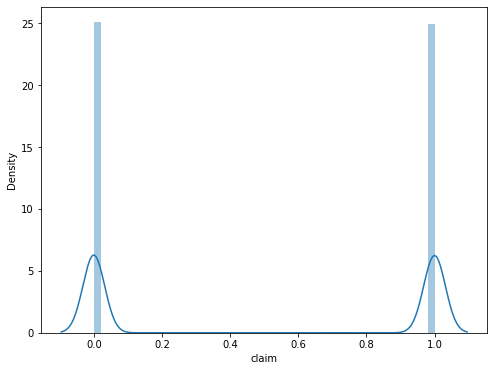

In [ ]:
# Импортируем необходимые библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# гистограмма
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['claim'])

Как мы и полагали, распределение далеко от идеального. 

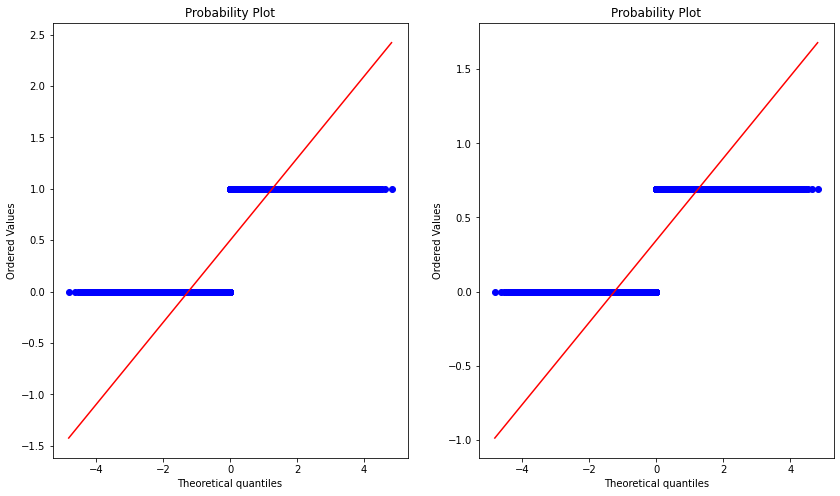

In [ ]:
from scipy import stats 

fig = plt.figure(figsize = (14,8))

# Распределение на необработанных данных
fig.add_subplot(1,2,1)
res = stats.probplot(train['claim'], plot=plt)

# Распределение при условии, что мы прологарифмировали 'SalePrice'
fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(train['claim']), plot=plt)

Этот метод построения признаков исправил ситуацию. Теперь наша задача – совершить логарифмирование не просто испытательным путем на графике, а применить данный метод ко всей тренировочной выборке:

In [ ]:
train['claim'] = np.log1p(train['claim'])

Обзор данных – корреляция
Теперь посмотрим, с какими признаками коррелирует целевая переменная claim:

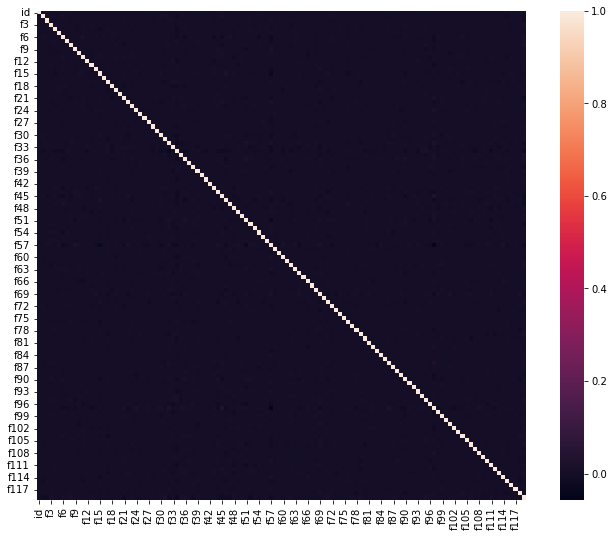

In [ ]:
# Матрица корреляции
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

Попробуем усеченный вариант и сократим количество коррелирующих признаков до 10:

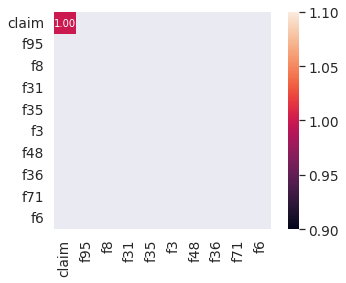

In [ ]:
k = 10 # количество коррелирующих признаков, которое мы хотим увидеть
cols = corrmat.nlargest(k, 'claim')['claim'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Теперь мы видим, что лучше всего claim коррелирует с f95 и f8. Проверим эти два признака на наличие выбросов:

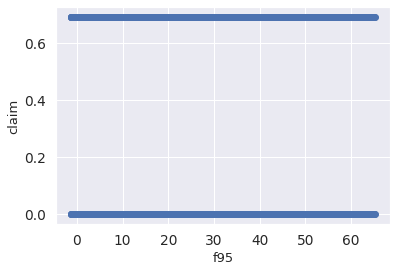

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train['f95'], y = train['claim'])
plt.ylabel('claim', fontsize=13)
plt.xlabel('f95', fontsize=13)
plt.show()

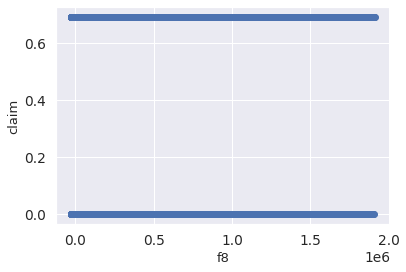

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train['f8'], y = train['claim'])
plt.ylabel('claim', fontsize=13)
plt.xlabel('f8', fontsize=13)
plt.show()

Явных выбросов нет

Очистка данных и отбор признаков
Далее стоит провести исследование данных на наличие пропущенных данных и других моментов, которые могут испортить score (а значит и нашу позицию в таблице лидеров соревнования).
Эта строчка кода выведет топ-20 пропущенных значений:

In [ ]:
train.isnull().sum().sort_values(ascending=False).head(20)

f31     15678
f46     15633
f24     15630
f83     15627
f68     15619
f103    15600
f95     15599
f12     15593
f116    15589
f64     15578
f57     15573
f74     15570
f76     15569
f50     15562
f60     15560
f4      15560
f115    15559
f39     15559
f69     15552
f88     15548
dtype: int64

Text(0.5, 1.0, 'Общее количество недостающих значений  (%)')

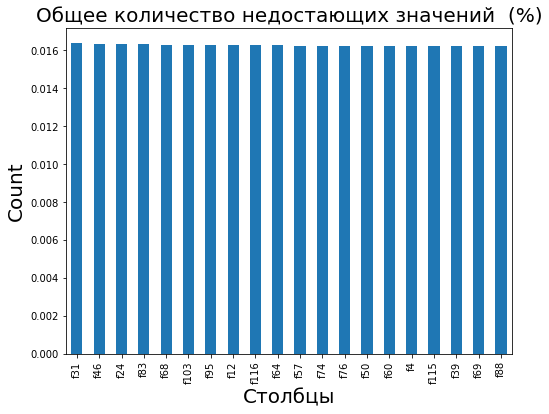

In [ ]:
# Визуализируем
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

# Гистограмма
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Столбцы", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Общее количество недостающих значений  (%)", fontsize = 20)

С этим необходимо разобраться. Большой количество пропущенных данных как в тренировочном, так и в тестовом датасете очень сильно ударит по качеству модели, а это прямая дорога на дно таблицы лидеров в соревновании.



In [ ]:
train.mean()

id       4.789590e+05
f1       9.020086e-02
f2       3.459637e-01
f3       4.068744e+03
f4       2.012140e-01
             ...     
f115     1.208876e+00
f116     4.276905e+16
f117     3.959205e+03
f118     5.592672e-01
claim    3.455284e-01
Length: 120, dtype: float64

In [5]:
# Пропущенные значения меняем на средние по столбцу
train.fillna(train.mean(), inplace=True)

In [ ]:
#train = train.fillna(0)


In [6]:
train[train.isnull().any(1)]

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim


In [7]:
print(train.isnull().sum())

id       0
f1       0
f2       0
f3       0
f4       0
        ..
f115     0
f116     0
f117     0
f118     0
claim    0
Length: 120, dtype: int64


In [8]:
test.fillna(test.mean(), inplace=True)

In [9]:
print(test.isnull().sum())

id      0
f1      0
f2      0
f3      0
f4      0
       ..
f114    0
f115    0
f116    0
f117    0
f118    0
Length: 119, dtype: int64


Выделим целевую переменную в отдельный формат и удалим ее из обучающей выборки.

In [10]:
y = np.array(train['claim'])
X = train.drop(['claim'], axis = 1)
X

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
0,0,0.108590,0.004314,-37.566,0.017364,0.289150,-10.25100,135.12,168900.0,3.992400e+14,...,0.110930,-12.2280,1.7482,1.90960,-7.115700,4378.80,1.2096,8.613400e+14,140.100000,1.01770
1,1,0.100900,0.299610,11822.000,0.276500,0.459700,-0.83733,1721.90,119810.0,3.874100e+15,...,0.976730,-56.7580,4.1684,0.34808,4.142000,913.23,1.2464,7.575100e+15,1861.000000,0.28359
2,2,0.178030,-0.006980,907.270,0.272140,0.459480,0.17327,2298.00,360650.0,1.224500e+13,...,0.201020,-5.7688,1.2042,0.26290,8.131200,45119.00,1.1764,3.218100e+14,3838.200000,0.40690
3,3,0.152360,0.007259,780.100,0.025179,0.519470,7.49140,112.51,259490.0,7.781400e+13,...,-0.011820,-34.8580,2.0694,0.79631,-16.336000,4952.40,1.1784,4.533000e+12,4889.100000,0.51486
4,4,0.116230,0.502900,-109.150,0.297910,0.344900,-0.40932,2538.90,65332.0,1.907200e+15,...,0.927390,-13.6410,1.5298,1.14640,-0.431240,3856.50,1.4830,-8.991300e+12,3959.204669,0.23049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957914,957914,0.098979,0.202530,2192.100,0.348010,0.276430,-0.84065,2214.20,26246.0,1.061600e+15,...,0.527470,-51.2970,1.7323,20.76300,14.744000,27415.00,1.2160,2.139400e+13,2612.000000,0.42597
957915,957915,0.134930,0.413600,1050.100,0.000521,-0.001246,1.76990,3519.90,862290.0,7.321400e+13,...,0.099876,-41.4180,2.6986,-1.09760,-1.099800,13826.00,1.3320,1.829400e+17,3300.500000,0.92974
957916,957916,0.104660,0.473510,2415.400,0.252230,0.196970,-0.82323,3044.90,13832.0,2.693300e+12,...,0.303780,-15.9670,1.6843,1.07590,16.646000,8655.10,1.1113,1.925800e+16,297.610000,0.91446
957917,957917,0.118190,0.320870,657.860,0.237290,0.260250,-0.71237,173.20,20811.0,9.711000e+14,...,0.001222,-2.8375,1.3006,132.50000,8.530500,3842.10,1.1941,1.248300e+16,5212.100000,0.20942


Создадим обучающую выборку Х, переведем получанные цифровые данные в np.array

In [11]:
X = np.array(X[X.columns])
X

array([[ 0.00000e+00,  1.08590e-01,  4.31390e-03, ...,  8.61340e+14,
         1.40100e+02,  1.01770e+00],
       [ 1.00000e+00,  1.00900e-01,  2.99610e-01, ...,  7.57510e+15,
         1.86100e+03,  2.83590e-01],
       [ 2.00000e+00,  1.78030e-01, -6.98000e-03, ...,  3.21810e+14,
         3.83820e+03,  4.06900e-01],
       ...,
       [ 9.57916e+05,  1.04660e-01,  4.73510e-01, ...,  1.92580e+16,
         2.97610e+02,  9.14460e-01],
       [ 9.57917e+05,  1.18190e-01,  3.20870e-01, ...,  1.24830e+16,
         5.21210e+03,  2.09420e-01],
       [ 9.57918e+05,  8.88320e-02,  4.72230e-01, ...,  1.21380e+16,
         2.13230e+03,  3.80690e-01]])

In [12]:
from sklearn.preprocessing import scale
X_scaled = scale(np.array(X, dtype='float'), with_std=True, with_mean=True)
X_scaled

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


array([[-1.732049  ,  0.42552055, -2.35480204, ..., -0.62760228,
        -1.21996361,  1.13145817],
       [-1.73204538,  0.24757566, -0.31949037, ..., -0.52705823,
        -0.67024436, -0.68039886],
       [-1.73204177,  2.03234674, -2.4326446 , ..., -0.63568218,
        -0.03865338, -0.37605743],
       ...,
       [ 1.73204177,  0.33458123,  0.87910555, ..., -0.35209725,
        -1.16964908,  0.87665151],
       [ 1.73204538,  0.64766242, -0.17295702, ..., -0.45355841,
         0.40022122, -0.86345785],
       [ 1.732049  , -0.03167518,  0.87028322, ..., -0.45872507,
        -0.58358108, -0.44074633]])

In [13]:
X.shape, y.shape

((957919, 119), (957919,))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [15]:
import warnings
from imblearn.under_sampling import TomekLinks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from random import sample
from sklearn.model_selection import cross_val_score, train_test_split
from  sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings("ignore")

In [16]:
params = {
        "random_state": 42,
        "eval_metric": "auc",
        "n_estimators" : 8000,
        "use_label_encoder" : "False",
        "max_depth" : 3,
        "learning_rate" : 0.027297134107723935,
        "colsample_bytree" : 0.7843918860573006,
        "objective" : "binary:logistic", 
        "subsample" : 0.7459596984766819,
        "gamma" : 0.05008218776821978,
        "reg_alpha" : 0.861755644724069,
        "reg_lambda" : 0.11499104081826494,
        "min_child_weight" : 227, 
        "booster" : "gbtree",
        # cpu
        #"n_jobs": -1,
        # gpu
        "predictor": "gpu_predictor",
        "tree_method": "gpu_hist"
    }

In [17]:
import xgboost as xgbm

In [18]:
model = xgbm.XGBClassifier(**params)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          early_stopping_rounds=300, verbose=1000)

[0]	validation_0-auc:0.520952
Will train until validation_0-auc hasn't improved in 300 rounds.
[1000]	validation_0-auc:0.75828
[2000]	validation_0-auc:0.779119
[3000]	validation_0-auc:0.783774
[4000]	validation_0-auc:0.785572
[5000]	validation_0-auc:0.786485
[6000]	validation_0-auc:0.786857
[7000]	validation_0-auc:0.787017
[7999]	validation_0-auc:0.78716


XGBClassifier(colsample_bytree=0.7843918860573006, eval_metric='auc',
              gamma=0.05008218776821978, learning_rate=0.027297134107723935,
              min_child_weight=227, n_estimators=8000,
              predictor='gpu_predictor', random_state=42,
              reg_alpha=0.861755644724069, reg_lambda=0.11499104081826494,
              subsample=0.7459596984766819, tree_method='gpu_hist',
              use_label_encoder='False')

In [19]:
from sklearn.metrics import roc_auc_score

In [20]:
test_norm = np.array(test[test.columns])
test_norm

array([[ 9.579190e+05,  1.658500e-01,  4.870500e-01, ...,  1.980400e+14,
         2.017100e+03,  4.635700e-01],
       [ 9.579200e+05,  1.296500e-01,  3.734800e-01, ...,  4.388000e+16,
         6.638900e+03,  2.812500e-01],
       [ 9.579210e+05,  1.201900e-01,  4.452100e-01, ...,  1.718100e+14,
         5.844000e+03,  1.379700e-01],
       ...,
       [ 1.451390e+06,  1.406200e-01,  4.847500e-01, ...,  7.900900e+16,
         2.904600e+03,  1.800500e-01],
       [ 1.451391e+06,  1.680000e-01,  3.517600e-01, ..., -1.770600e+14,
         6.763100e+03,  3.322300e-01],
       [ 1.451392e+06,  9.307900e-02,  5.018600e-01, ...,  2.459300e+15,
         8.770000e+03,  9.550300e-01]])

In [ ]:
#test_norm = scale(np.array(test_norm, dtype='float'), with_std=True, with_mean=True)
#test_norm

array([[-1.7320473 ,  1.7516978 ,  0.97367281, ..., -0.63758013,
        -0.62222421, -0.23485895],
       [-1.73204028,  0.91357442,  0.18890239, ...,  0.01551056,
         0.85142028, -0.68481465],
       [-1.73203326,  0.69455102,  0.68455778, ..., -0.63797229,
         0.59796924, -1.03842178],
       ...,
       [ 1.73203326,  1.16755822,  0.95777978, ...,  0.5407256 ,
        -0.339248  , -0.93457066],
       [ 1.73204028,  1.80147585,  0.03881686, ..., -0.64318826,
         0.891021  , -0.55899882],
       [ 1.7320473 ,  0.06686143,  1.07601014, ..., -0.60377194,
         1.53091393,  0.9780372 ]])

In [21]:
predict = model.predict(test_norm)

In [22]:
predict

array([0, 0, 0, ..., 1, 0, 1])

In [23]:
sample =pd.read_csv('/content/drive/MyDrive/my_databases/tabular-playground-series-sep-2021/sample_solution.csv')

In [24]:
submission =pd.read_csv('/content/drive/MyDrive/my_databases/tabular-playground-series-sep-2021/sample_solution.csv')
submission.claim = predict
submission.to_csv('submission.csv', index=False)